#### output weights 2 layer, threads, validation set, graph plot, test set, lstm cell stack, preloaded full data before training.

In [1]:
from sklearn import metrics
import tensorflow as tf
import csv
from threading import Thread
from matplotlib import pyplot as plt
from  read_proces_data import *

In [ ]:
# set variables holding data, sequence length and target values
inde_featuress = []
# max time steps to roll back
sseq_len = []
# actual output to predict
target_valuess = []
# hidden units for lstm
hidden_units = 128
# Lstm layers
num_layers = 2
# chunks of input given to lstm at a time for training
batch_size = 20
# max seq length in training and test data
max_seq = 3260
# input dimension
feature_vec_len = 57

In [5]:
# find max no of times to roll back
#max_seq_len = find_max_seq_len()
#print max_seq_len
max_seq_len = 3259

In [6]:
# function to read data from file, 
# based on maximum seq length add padding,
# find independent features and 
# append to list already containing previously loaded data
# also load target values for each seq of input.
def data_processing(file_name):
    # get features from current indexed file
    features = get_train_data(file_name)
    # get target values corresponding to this file
    target_valuess.append(get_target_values(file_name))
    # training features is np array with max size and padding
    training_features, s_l = prepare_data(features, max_seq_len)
    sseq_len.append(s_l)
    # scale features to have 0 mean and 1 variance
    scaled_features = feature_scaling(training_features, batch_size,\
            s_l)
    # find independent components from given features
    inde_featuress.append(independent_components(scaled_features, batch_size,\
            s_l))

In [ ]:
#Load full training data in memory before training starts
for file_ in file_dir:
    data_processing(file_)
print len(inde_featuress)
print len(sseq_len)
print len(target_valuess)

In [2]:
sess = tf.InteractiveSession()

In [3]:
# create lstm cell in tensorflow
def lstm_cell():
    return tf.contrib.rnn.BasicLSTMCell(num_units =\
        hidden_units,state_is_tuple=True)
stacked_cell = tf.contrib.rnn.MultiRNNCell(\
        [lstm_cell() for _ in range(num_layers)], \
        state_is_tuple=True)

In [4]:
x = tf.placeholder(tf.float32, shape = [batch_size,max_seq,feature_vec_len])
s_len = tf.placeholder(tf.int32,shape=[batch_size])
# run lstm over different sequence length
output_, state = tf.nn.dynamic_rnn(\
        stacked_cell,\
        x,\
#        initial_state = i_state,\
        sequence_length=s_len,\
        dtype=tf.float32)
# take all batch, last output of each batch and full output vector
def take_subarray(array , index):
    return array[range(0,batch_size),index-1]
output = tf.py_func(take_subarray,[output_,s_len],tf.float32)
#print output
# define final output value
target_value = tf.placeholder(tf.float32, shape=[batch_size])
# define weights and bias from output of lstm cell to network final output
output_size = stacked_cell.output_size

rv1 = tf.truncated_normal([output_size, 2 * output_size],\
        stddev=0.1,dtype=tf.float32)
Wo1 = tf.Variable(rv1,dtype=tf.float32)

rv2 = tf.truncated_normal([2 * output_size, 2 * output_size],\
        stddev=0.1,dtype=tf.float32)
Wo2 = tf.Variable(rv2,dtype=tf.float32)

rv3 = tf.truncated_normal([2 * output_size, 1],\
        stddev=0.1,dtype=tf.float32)
Wo3 = tf.Variable(rv3,dtype=tf.float32)

rb1 = tf.constant(0.1,shape=[2 * output_size],dtype=tf.float32)
b1 = tf.Variable(rb1,dtype=tf.float32)

rb2 = tf.constant(0.1,shape=[2 * output_size],dtype=tf.float32)
b2 = tf.Variable(rb2,dtype=tf.float32)

rb3 = tf.constant(0.1,shape=[1],dtype=tf.float32)
b3 = tf.Variable(rb3,dtype=tf.float32)
# initialize variables
# calculate final output

s1  = tf.matmul(output, Wo1) + b1
o1 = tf.nn.relu(s1)

s2  = tf.matmul(o1, Wo2) + b2
o2 = tf.nn.relu(s2)

logits  = tf.matmul(o2, Wo3) + b3
observed = tf.sigmoid(logits)
#observed = tf.nn.relu(logits)

# calculate cost as calculated in logistic classification.
logistic_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
        labels = tf.reshape(target_value,[batch_size,1]), logits = logits))
#cost = tf.reduce_mean(-1.0 * target_value * tf.log(observed) - \
#        (1 - target_value) * tf.log(1 - observed))
#cost = tf.reduce_mean(-1 * target_value * tf.log(observed))
#cost = tf.reduce_mean(tf.square(target_value - observed))
# optimize the cost
train_step = tf.train.AdamOptimizer(1e-4).minimize(logistic_cost)
def threshold_fn(array):
    return array >= 0.50
obser = tf.py_func(threshold_fn,[observed], tf.bool)
observe = tf.cast(obser,tf.float32)

sess.run(tf.global_variables_initializer())

In [7]:
def file_evaluate(data):
    # evaluate over whole file
    y = np.zeros(0)
    if "Sess05" in data[0]:
#                print file_
#                print inde_features.shape
        for index in range(0,100,batch_size):
#                    print inde_features[index:index+batch_size].shape                    
            #print inde_features.shape
            yfile = sess.run(observe, feed_dict = {\
                x:data[1][index:index+batch_size], \
                s_len:data[2][index:index+batch_size]})
            y = np.append(y,yfile)
    else:
        for index in range(0,60,batch_size):
            yfile = sess.run(observe, feed_dict = {\
                x:data[1][index:index+batch_size], \
                s_len:data[2][index:index+batch_size]})
            y = np.append(y,yfile)

    f1score = metrics.f1_score(data[3],y)
#    print "f1-score of file is %f"%f1score
    fprr, tprr, thresholds = metrics.roc_curve(data[3], y, pos_label=1)
    aucc = metrics.auc(fprr,tprr)
#    print "area under curve of file is %f"%aucc
    sk_acc = metrics.accuracy_score(data[3],y)
#    print "accuracy of file is %f"%sk_acc
#    print " "
    return (f1score, aucc, sk_acc)

In [8]:
def train_eval(train_data, val_data):
    max_iter = 3000
    for i in range(0,max_iter):
        tr_fe, sl , tv =\
        sample_data(train_data[1],train_data[3],train_data[2],batch_size)

        sess.run(train_step, feed_dict = {target_value:tv,\
                x:tr_fe, s_len:sl})

        if i == max_iter-1:
            #print "iteration %d"%i
            print "cost %f"%sess.run(logistic_cost, feed_dict = {target_value:tv,\
                x:tr_fe, s_len:sl})
            # collect values to print graph later
            t_f1s, t_auc, t_acc = file_evaluate(train_data)
            train_para.append([t_f1s, t_auc, t_acc])
            # collect values to print graph later
            v_f1s, v_auc, v_acc = file_evaluate(val_data)
            vali_para.append([v_f1s, v_auc, v_acc])
            
#            y = sess.run(observe, feed_dict = {x:tr_fe, s_len:sl})            
#            f1s = metrics.f1_score(tv,y)
#            print "f1-score is %f"%f1s
#            fpr, tpr, thresholds = metrics.roc_curve(tv, y, pos_label=1)
#            auc = metrics.auc(fpr,tpr)
#            print "area under curve is %f"%auc
#            sk_accuracy = metrics.accuracy_score(tv,y)
#            print "accuracy %f"%sk_accuracy

In [9]:
def plot_parameters(training_p, validation_p):
    nu_para = training_p.shape[1]
    para_name = ['f1score','auc','accuracy']
    for j in range(nu_para):
        plt.subplot(nu_para,1,j+1)
        plt.plot(training_p[:,j],'r')
        plt.plot(validation_p[:,j],'b')
        plt.ylabel(para_name[j])
        plt.draw()
    plt.show()

cost 0.438026
cost 0.500181
cost 0.583840
cost 0.566224
cost 0.000246
cost 0.539486
cost 0.470750
cost 0.564048
cost 0.625600
cost 0.443688
cost 0.641126
cost 0.279299
cost 0.459868
cost 0.619272
cost 0.419767
cost 0.563104
cost 0.352105
cost 0.358341
cost 0.633012
cost 0.443974
cost 0.521750
cost 0.471992
cost 0.319724
cost 0.440272
cost 0.456932
cost 0.519354
cost 0.577820
cost 0.443383
cost 0.527048
cost 0.597385
cost 0.492218
cost 0.386182
cost 0.490001


/usr/local/lib/python2.7/dist-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


cost 0.456072
cost 0.481503
cost 0.422352
cost 0.383160
cost 0.386583
cost 0.513504
cost 0.455025
cost 0.437640
cost 0.472076
cost 0.564182
cost 0.566778
cost 0.552093
cost 0.506700
cost 0.449650
cost 0.453770
cost 0.624408
cost 0.412188
cost 0.519465
cost 0.484889
cost 0.393555
cost 0.489047
cost 0.531005
cost 0.384364
cost 0.431795
cost 0.482498
cost 0.557459
cost 0.483000
cost 0.449193
cost 0.523622
cost 0.571764
cost 0.555533
cost 0.519525
cost 0.416805
cost 0.507298
cost 0.542330
cost 0.493867
cost 0.530622
cost 0.588931
cost 0.578207
cost 0.392531
cost 0.522045
cost 0.417442
cost 0.577566
cost 0.398961
cost 0.601610
cost 0.549045


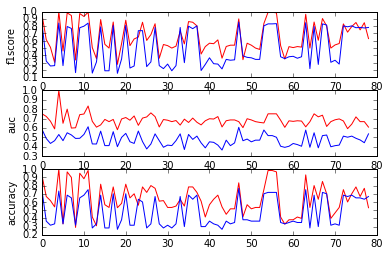

In [10]:
# number of times to iterate over whole training dataset
#check_1_time = 1
iter_over_files =  1
for itera in range(0, iter_over_files):
    dir_len = len(file_dir)
    # select file to treat as validation set
    val_file_no = np.random.randint(low=0,high=dir_len)
    val_file = file_dir[val_file_no]
    # train_para and vali_para are storing f1score,auc,accuracy for 
    # train and validation set.
    train_para = []
    vali_para = []
    
#    data_thread = Thread(target=data_processing,args=(val_file,))
#    data_thread.start()
#    data_thread.join()
    # collect validation data in one list to reduce no of parameters
    # to pass between functions
    val_data = [val_file, inde_featuress[val_file_no], \
                sseq_len[val_file_no], target_valuess[val_file_no]]
    # reset these so that these can be used in the below call of data_processing
    #inde_featuress = []
    #sseq_len = []
    #target_valuess = []
    # iterate over each file and train
    for index in range(0, dir_len:
        # do not train on validation file
        if index == val_file_no:
            continue
        #data_thread = Thread(target=data_processing,args=(file_,))
        #data_thread.start()
        #data_thread.join()
        #print "reading data file %s"%file_
        # collect values to form a list to reduce the parameters to be passed
        #train_data = [file_, inde_featuress, sseq_len, target_valuess]
        # reset the values to be used in next call of either val or train set
        train_data = [file_dir[index], inde_featuress[index], \
                    sseq_len[index], target_valuess[index]]
        #inde_featuress = []
        #sseq_len = []
        #target_valuess = []
        
        #if 1!=check_1_time:
        #    tr_ev_thread.join()
#        print thread_inde_features[0].shape
        #tr_ev_thread = Thread(target = train_eval, args = \
        train_eval(train_data, val_data)
        3#tr_ev_thread.start()
        check_1_time = 0
        
    #tr_ev_thread.join()
    
    t_para = np.asarray(train_para)
    v_para = np.asarray(vali_para)
    
    plot_parameters(t_para, v_para)

In [11]:
# predict values for test data set
print ('opening file for write')
label = ["IdFeedBack,Prediction"]
with open('output.csv', 'wb') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=' ')
    spamwriter.writerow(label)

    for file_ in test_file_dir:
        # get features from current indexed file
        features = get_test_data(file_)        
        # training features is np array with max size and padding
        test_features, seq_len = prepare_data(features, max_seq_len)
        # scale features to have 0 mean and 1 variance
        scaled_features = feature_scaling(test_features, batch_size,\
                seq_len)
        # find independent components from given features
        inde_features = independent_components(scaled_features, batch_size,\
                seq_len)
        # evaluate over whole file
        y = np.zeros(0)
        if "Sess05" in file_:
            indices = ["%03d" %(i+1) for i in range(100)]
    #        print file_
            for index in range(0,100,batch_size):
                yfile = observe.eval(feed_dict = {\
                    x:inde_features[index:index+batch_size], \
                    s_len:seq_len[index:index+batch_size]})
                y = np.append(y,yfile)
        else:
            indices = ["%03d" %(i+1) for i in range(60)]
            for index in range(0,60,batch_size):
                yfile = observe.eval(feed_dict = {\
                    x:inde_features[index:index+batch_size], \
                    s_len:seq_len[index:index+batch_size]})
                y = np.append(y,yfile)

        for i in xrange(0,y.shape[0]):
            values = [file_[5:-4]+'_FB'+indices[i]+','+str(int(y[i]))]
            spamwriter.writerow(values)
print ('file write complete')

opening file for write
file write complete
